# DER系アプローチの分析用ノートブック

In [1]:
from pathlib import Path
import itertools
import os, sys, json, re
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 例: 物理GPU1番だけを見せる
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

## 1) Project root / config / phase 設定

In [3]:
# === プロジェクトルートの指定 ===
# Notebook を CIDL-main の直下で開いているなら "." で OK
PROJECT_ROOT = Path("/home/kouyou/ContinualLearning/repexp/PyCIL").resolve()
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

from trainer import _set_device  # 既存のヘルパをそのまま使う
from utils.data_manager import DataManager
from utils import factory

# === 使いたい設定ファイルと、どの phase を可視化するか ===
CONFIG_PATH = "exps/der_mu/baseline0/cifar100.json"   # 適宜変更
PHASE_ID    = 5                                         # ex) タスク3終了時のモデル → phase3.pkl

# === json 読み込み → args にする ===
with open(CONFIG_PATH) as f:
    args = json.load(f)

# device を training と同じ形式 (list of torch.device) に変換
_set_device(args)

print("model_name:", args["model_name"])
print("dataset   :", args["dataset"])
print("device    :", args["device"])

model_name: der-mu
dataset   : cifar100
device    : [device(type='cuda', index=0)]


## 2) Checkpoint path を trainer と同じ規則で組み立てる

In [24]:
from glob import glob

def _seed_to_str(seed):
    # trainer.py は args['seed'] をそのまま format しているので、list/int 両対応にしておく
    if isinstance(seed, (list, tuple)):
        return str(seed[0]) if len(seed) else "0"
    return str(seed)

def build_ckpt_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

ckpt_dir  = build_ckpt_dir(args)
# ckpt_path = f"{ckpt_dir}/phase_{PHASE_ID}.pkl"
# ckpt_path = f"{ckpt_dir}/phase_{PHASE_ID}_unlearn_pruned[50, 51].pth"
ckpt_path = f"{ckpt_dir}/phase_{PHASE_ID}_cos_unlearn_maskft[50, 51]_v6.pth"


print("ckpt_dir :", ckpt_dir)
print("ckpt_path:", ckpt_path)

# # もし exists が False のときは、pattern で探す fallback も書いておくと楽
# if not ckpt_path.exists():
#     cand = glob(str(ckpt_dir / f"phase{PHASE_ID}*.pkl"))
#     print("fallback candidates:", cand)


ckpt_dir : logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/
ckpt_path: logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32//phase_5_cos_unlearn_maskft[50, 51]_v6.pth


logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/phase_5_cos_unlearn_maskft[50, 51].pth

## 3) DataManager と model を作って checkpoint をロード（DER/TagFex など拡張系対応）

In [25]:
def infer_convnet_count_from_state_dict(state_dict):
    # keys like: 'convnets.0.xxx', 'convnets.1.xxx', ...
    idxs = []
    pat = re.compile(r"^convnets\.(\d+)\.")
    for k in state_dict.keys():
        m = pat.match(k)
        if m:
            idxs.append(int(m.group(1)))
    return (max(idxs) + 1) if idxs else 0

def classes_at_task(k, args, total_classnum):
    # task k の終了時点での total_classes（BaseLearnerの挙動に合わせる）
    init_cls = args["init_cls"]
    inc = args["increment"]
    num = init_cls + k * inc
    return min(num, total_classnum)

def build_network_skeleton_for_ckpt(model, state_dict, data_manager, args, phase_id):
    """state_dict をロード可能な形に network を拡張しておく。
    DERNet/TagFexNet 系は update_fc を task 回数ぶん呼ぶ必要がある。
    """
    net = model._network
    # DataParallel だと update_fc が面倒なので notebook では使わない前提
    if isinstance(net, torch.nn.DataParallel):
        net = net.module
        model._network = net

    convnet_count = infer_convnet_count_from_state_dict(state_dict)
    if convnet_count == 0:
        # ふつうはありえないが、念のため
        convnet_count = phase_id + 1

    # 最終クラス数は fc.weight の out_features で確定できる
    if "fc.weight" in state_dict:
        final_classes = state_dict["fc.weight"].shape[0]
    else:
        # fallback
        final_classes = classes_at_task(phase_id, args, data_manager.get_total_classnum())

    # すでに update_fc 済みのモデルなら二重に増やさない
    existing = len(getattr(net, "convnets", [])) if hasattr(net, "convnets") else 0

    # DER/TagFex 系は convnets を持つ。ここが最重要分岐。
    if hasattr(net, "update_fc") and hasattr(net, "convnets"):
        # 必要な回数だけ update_fc を呼ぶ
        # task k でのクラス数を与えながら進める（最後だけ final_classes で整合）
        total_cls = data_manager.get_total_classnum()
        for k in range(existing, convnet_count):
            nb = classes_at_task(k, args, total_cls)
            # 最後の update_fc は checkpoint の fc 次元に合わせる
            if k == convnet_count - 1:
                nb = final_classes
            net.update_fc(nb)
    else:
        # 拡張なしモデルは update_fc 1回で十分なことが多い
        if hasattr(net, "update_fc") and "fc.weight" in state_dict:
            net.update_fc(state_dict["fc.weight"].shape[0])

    return net

# --- DataManager & model ---
data_manager = DataManager(
    dataset_name=args["dataset"],
    shuffle=args.get("shuffle", True),
    seed=int(_seed_to_str(args.get("seed", 0))),
    init_cls=args["init_cls"],
    increment=args["increment"],
)

model = factory.get_model(args["model_name"], args)
model._device = args["device"][0]
model._network.to(model._device)

ckpt = torch.load(ckpt_path, map_location=model._device)
# state_dict = ckpt["model_state_dict"]
state_dict = ckpt["state_dict"]


# 1) skeleton を作る（update_fc を必要回数）
build_network_skeleton_for_ckpt(model, state_dict, data_manager, args, PHASE_ID)

# 2) state_dict ロード
model._network.load_state_dict(state_dict, strict=True)
model._network.to(model._device)

# 3) 追加情報（あれば）
if "forget_classes" in ckpt and hasattr(model, "forget_classes"):
    model.forget_classes = ckpt["forget_classes"]
if "protos" in ckpt:
    model._protos = ckpt["protos"]

model._network.eval()
print("loaded. convnets =", len(getattr(model._network, "convnets", [])))


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-25-771262224df8>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=model._device)


loaded. convnets = 6


## 4) 対象クラス（task t のクラス集合）

In [26]:
# --- 対象クラスの指定方法 ---
# "manual": クラスIDを手で指定
# "task"  : これまで通り task_id から自動生成（残しておくと便利）
TARGET_MODE = "manual"   # ←ここを "manual" にしてください

# manual のときに使う（例）
# MANUAL_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # ←ここを好きなクラス集合に
MANUAL_CLASSES = [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]  # ←ここを好きなクラス集合に



def get_task_classes(task_id, args, data_manager):
    init_cls = args["init_cls"]
    inc = args["increment"]
    start = 0 if task_id == 0 else init_cls + (task_id - 1) * inc
    end   = init_cls if task_id == 0 else init_cls + task_id * inc
    end = min(end, data_manager.get_total_classnum())
    return np.arange(start, end, dtype=int)

if TARGET_MODE == "manual":
    target_classes = np.array(MANUAL_CLASSES, dtype=int)
elif TARGET_MODE == "task":
    TARGET_TASK = PHASE_ID  # 好きに変更
    target_classes = get_task_classes(TARGET_TASK, args, data_manager)
else:
    raise ValueError(f"Unknown TARGET_MODE: {TARGET_MODE}")

print("TARGET_MODE:", TARGET_MODE)
print("target_classes:", target_classes[:20], "... total", len(target_classes))
print("unique?", len(np.unique(target_classes)) == len(target_classes))


TARGET_MODE: manual
target_classes: [50 51 52 53 54 55 56 57 58 59] ... total 10
unique? True


## 5) Dataset / DataLoader

In [27]:
batch_size = 128
num_workers = 8

train_dataset = data_manager.get_dataset(target_classes, source="train", mode="test")
test_dataset  = data_manager.get_dataset(target_classes, source="test",  mode="test")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

len(train_dataset), len(test_dataset)


(5000, 1000)

## 6) Backboneごとの feature 抽出（concat前）

In [28]:
def _unwrap_net(net):
    return net.module if isinstance(net, torch.nn.DataParallel) else net

def get_backbones_from_net(net):
    net = _unwrap_net(net)
    if hasattr(net, "convnets"):
        return list(net.convnets)
    raise AttributeError("This net does not have `convnets` (expected DERNet/TagFexNet-like).")

@torch.no_grad()
def extract_vectors_preconcat_by_backbone(net, loader, device):
    net = _unwrap_net(net)
    backbones = get_backbones_from_net(net)
    net.eval()
    for bb in backbones:
        bb.to(device)
        bb.eval()

    feats_by_bb = [[] for _ in range(len(backbones))]
    labels_all = []

    for _, (_, x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        labels_all.append(y.numpy())

        for i, bb in enumerate(backbones):
            out = bb(x)
            f = out["features"] if isinstance(out, dict) and "features" in out else out
            feats_by_bb[i].append(f.detach().cpu().numpy())

    feats_by_bb = [np.concatenate(v, axis=0).astype(np.float32) for v in feats_by_bb]
    labels = np.concatenate(labels_all, axis=0).astype(np.int64)
    return feats_by_bb, labels

features_by_bb_train, y_train_raw = extract_vectors_preconcat_by_backbone(model._network, train_loader, model._device)
features_by_bb_test,  y_test_raw  = extract_vectors_preconcat_by_backbone(model._network, test_loader,  model._device)

print("num_backbones:", len(features_by_bb_train))
print("train shapes:", [f.shape for f in features_by_bb_train])
print("test  shapes:", [f.shape for f in features_by_bb_test])


num_backbones: 6
train shapes: [(5000, 64), (5000, 64), (5000, 64), (5000, 64), (5000, 64), (5000, 64)]
test  shapes: [(1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64), (1000, 64)]


## 7) backbone subset（concat指定）を決める（要件1）

In [29]:
def make_bb_sets(num_backbones: int,
                 mode: str = "manual",
                 manual_sets=None,
                 sizes=(1,),
                 max_sets=200,
                 seed=0):
    rng = np.random.RandomState(seed)

    if mode == "single+all":
        return [[i] for i in range(num_backbones)] + [list(range(num_backbones))]

    if mode == "leave_one_out":
        all_set = list(range(num_backbones))
        return [all_set] + [[i for i in all_set if i != j] for j in all_set]

    if mode == "manual":
        if manual_sets is None:
            return [[num_backbones-1], list(range(num_backbones))]
        return [sorted(list(s)) for s in manual_sets]

    if mode == "combinations":
        all_sets = []
        for k in sizes:
            if k <= 0 or k > num_backbones:
                continue
            for comb in itertools.combinations(range(num_backbones), k):
                all_sets.append(list(comb))
        if len(all_sets) > max_sets:
            idx = rng.choice(len(all_sets), size=max_sets, replace=False)
            all_sets = [all_sets[i] for i in idx]
        return all_sets

    raise ValueError(f"Unknown mode: {mode}")

B = len(features_by_bb_train)

BB_SET_MODE = "combinations"   # "manual" / "single+all" / "leave_one_out" / "combinations"
# MANUAL_BB_SETS = [[1, 2, 3, 4, 5, 6, 7, 8, 9],
#                   [0, 2, 3, 4, 5, 6, 7, 8, 9],
#                   [0, 1, 3, 4, 5, 6, 7, 8, 9],
#                   [0, 1, 2, 4, 5, 6, 7, 8, 9],
#                   [0, 1, 2, 3, 5, 6, 7, 8, 9],
#                   [0, 1, 2, 3, 4, 6, 7, 8, 9],
#                   [0, 1, 2, 3, 4, 5, 7, 8, 9],
#                   [0, 1, 2, 3, 4, 5, 6, 8, 9],
#                   [0, 1, 2, 3, 4, 5, 6, 7, 9],
#                   [0, 1, 2, 3, 4, 5, 6, 7, 8],
#                   list(range(B))]
MANUAL_BB_SETS = [[0, 1],
                  [2, 3],
                  [4, 5],
                  [6, 7],
                  [8, 9],
                  [0, 1, 2],
                  [0, 1, 3],
                  [4, 5],
                  [6, 7],
                  [8, 9],
                  [0],
                  [1],
                  [2],
                  [3],
                  [5],
                  [6],
                  [7],
                  [8],
                  [9],
                  list(range(B))]
BB_SET_SIZES = (1,2)
MAX_SETS = 200

BB_SETS = make_bb_sets(B, mode=BB_SET_MODE, manual_sets=MANUAL_BB_SETS,
                       sizes=BB_SET_SIZES, max_sets=MAX_SETS, seed=0)

print("BB_SET_MODE:", BB_SET_MODE, "num sets:", len(BB_SETS))
print("example:", BB_SETS[:10])


BB_SET_MODE: combinations num sets: 21
example: [[0], [1], [2], [3], [4], [5], [0, 1], [0, 2], [0, 3], [0, 4]]


## 8) k-NN 実装（chunked top-k）

In [30]:
def remap_labels(y, classes):
    classes = np.array(classes, dtype=int)
    idx = {int(c):i for i,c in enumerate(classes.tolist())}
    y2 = np.array([idx[int(t)] for t in y], dtype=np.int64)
    inv = {v:k for k,v in idx.items()}
    return y2, idx, inv

def concat_bbs(features_by_bb, bb_ids):
    return np.concatenate([features_by_bb[i] for i in bb_ids], axis=1).astype(np.float32)

def _normalize_rows(x: torch.Tensor, eps=1e-12):
    return x / (x.norm(dim=1, keepdim=True) + eps)

@torch.no_grad()
def knn_predict_chunked(
    X_train: np.ndarray, y_train: np.ndarray,
    X_test: np.ndarray,
    num_classes: int,
    k: int = 5,
    metric: str = "cosine",      # "cosine" or "l2"
    device: str = "cuda:0",
    test_chunk: int = 512,
    train_chunk: int = 8192,
    normalize: bool = True,
):
    Xtr = torch.from_numpy(X_train)
    ytr = torch.from_numpy(y_train).long()
    Xte = torch.from_numpy(X_test)

    if normalize:
        Xtr = _normalize_rows(Xtr)
        Xte = _normalize_rows(Xte)

    ytr_cpu = ytr
    Ntr = Xtr.shape[0]
    Nte = Xte.shape[0]

    preds = []
    for i0 in range(0, Nte, test_chunk):
        xb = Xte[i0:i0+test_chunk].to(device, non_blocking=True)
        Bsz = xb.shape[0]

        best_vals = torch.full((Bsz, k), -1e9, device=device)
        best_idx  = torch.full((Bsz, k), -1,   device=device, dtype=torch.long)

        if metric == "l2":
            xb_norm = (xb * xb).sum(dim=1, keepdim=True)

        for j0 in range(0, Ntr, train_chunk):
            xtr = Xtr[j0:j0+train_chunk].to(device, non_blocking=True)
            if metric == "cosine":
                sim = xb @ xtr.t()
                vals, idx = torch.topk(sim, k=min(k, sim.shape[1]), dim=1, largest=True)
            elif metric == "l2":
                xtr_norm = (xtr * xtr).sum(dim=1, keepdim=True).t()
                dist2 = xb_norm + xtr_norm - 2.0 * (xb @ xtr.t())
                sim = -dist2
                vals, idx = torch.topk(sim, k=min(k, sim.shape[1]), dim=1, largest=True)
            else:
                raise ValueError("metric must be 'cosine' or 'l2'")

            idx = idx + j0

            merged_vals = torch.cat([best_vals, vals], dim=1)
            merged_idx  = torch.cat([best_idx,  idx],  dim=1)
            best_vals, topk_pos = torch.topk(merged_vals, k=k, dim=1, largest=True)
            best_idx = torch.gather(merged_idx, 1, topk_pos)

        # nn_labels = ytr_cpu[best_idx.cpu().numpy()]  # [B,k]
        # nn_labels = torch.from_numpy(nn_labels).to(device)
        # counts = F.one_hot(nn_labels, num_classes=num_classes).sum(dim=1)
        # pred = counts.argmax(dim=1).cpu().numpy()
        # preds.append(pred)

        # vote
        nn_labels = ytr_cpu[best_idx.cpu()]              # [B,k] torch.Tensor (CPU)
        nn_labels = nn_labels.to(device, non_blocking=True)

        counts = F.one_hot(nn_labels, num_classes=num_classes).sum(dim=1)  # [B,C]
        pred = counts.argmax(dim=1).cpu().numpy()
        preds.append(pred)

    return np.concatenate(preds, axis=0)

def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.int64)
    y_pred = np.asarray(y_pred, dtype=np.int64)
    return float((y_true == y_pred).mean() * 100.0)

def per_class_accuracy(y_true, y_pred, num_classes):
    y_true = np.asarray(y_true, dtype=np.int64)
    y_pred = np.asarray(y_pred, dtype=np.int64)
    total = np.bincount(y_true, minlength=num_classes).astype(np.int64)
    corr = np.bincount(y_true[y_true == y_pred], minlength=num_classes).astype(np.int64)
    acc = np.zeros((num_classes,), dtype=np.float64)
    nonzero = total > 0
    acc[nonzero] = (corr[nonzero] / total[nonzero]) * 100.0
    return acc, corr, total


## 9) k-NN 評価を実行（要件1 & 要件2）

In [31]:
# --- k-NN params ---
K_LIST = [151]
METRIC = "cosine"        # "cosine" or "l2"
NORMALIZE = True
TEST_CHUNK = 512
TRAIN_CHUNK = 8192

SHOW_PER_CLASS = True    # 要件2
PER_CLASS_TOPK = 20
PER_CLASS_FOR = "all"   # "best" / "all" / "manual"
PER_CLASS_BB_IDS = BB_SETS[0] if len(BB_SETS) else [0]

# remap labels to 0..C-1
y_train, _, inv = remap_labels(y_train_raw, target_classes)
y_test,  _, _   = remap_labels(y_test_raw,  target_classes)

rows = []
per_class_store = {}  # (bb_ids_str, k) -> per-class acc array

for bb_ids in BB_SETS:
    Xtr = concat_bbs(features_by_bb_train, bb_ids)
    Xte = concat_bbs(features_by_bb_test,  bb_ids)

    for k in K_LIST:
        y_pred = knn_predict_chunked(
            Xtr, y_train, Xte,
            num_classes=len(target_classes),
            k=k, metric=METRIC,
            device=str(model._device),
            test_chunk=TEST_CHUNK,
            train_chunk=TRAIN_CHUNK,
            normalize=NORMALIZE,
        )
        acc = accuracy(y_test, y_pred)
        rows.append({
            "bb_ids": str(bb_ids),
            "size": len(bb_ids),
            "dim": int(Xtr.shape[1]),
            "k": int(k),
            "metric": METRIC,
            "acc_all(%)": acc,
        })

        if SHOW_PER_CLASS:
            pc_acc, _, _ = per_class_accuracy(y_test, y_pred, num_classes=len(target_classes))
            per_class_store[(str(bb_ids), int(k))] = pc_acc

import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)   # 列も全部見たいなら
pd.set_option("display.width", 0)            # 折り返し調整（環境による）

df_res = pd.DataFrame(rows).sort_values(["acc_all(%)", "size"], ascending=[False, True]).reset_index(drop=True)
df_res


,bb_ids,size,dim,k,metric,acc_all(%)
0,"[0, 5]",2,128,151,cosine,85.2
1,"[2, 5]",2,128,151,cosine,84.9
2,"[1, 5]",2,128,151,cosine,84.8
3,"[3, 5]",2,128,151,cosine,84.4
4,"[4, 5]",2,128,151,cosine,83.7
5,[5],1,64,151,cosine,80.9
6,"[1, 3]",2,128,151,cosine,65.0
7,"[1, 2]",2,128,151,cosine,64.6
8,"[1, 4]",2,128,151,cosine,64.1
9,"[2, 4]",2,128,151,cosine,63.8


## 10) クラス別精度の表示（要件2）

In [32]:
if not SHOW_PER_CLASS:
    print("SHOW_PER_CLASS=False")
else:
    def show_per_class_table(bb_ids_str, k):
        key = (bb_ids_str, int(k))
        if key not in per_class_store:
            print("not found:", key)
            return
        pc = per_class_store[key]
        orig_cls = np.array([inv[i] for i in range(len(target_classes))], dtype=int)
        df_pc = pd.DataFrame({"class": orig_cls, "acc(%)": pc})
        df_pc_sorted = df_pc.sort_values("acc(%)", ascending=False).reset_index(drop=True)

        print("Top classes")
        display(df_pc_sorted.head(PER_CLASS_TOPK))
        print("Bottom classes")
        display(df_pc_sorted.tail(PER_CLASS_TOPK))
        return df_pc_sorted

    if PER_CLASS_FOR == "best":
        best = df_res.iloc[0]
        print("Best setting:", dict(best))
        show_per_class_table(best["bb_ids"], best["k"])
    elif PER_CLASS_FOR == "all":
        for _, row in df_res.iterrows():
            print("Setting:", row["bb_ids"], "k=", row["k"], "acc=", row["acc_all(%)"])
            show_per_class_table(row["bb_ids"], row["k"])
    elif PER_CLASS_FOR == "manual":
        bb_ids_str = str(PER_CLASS_BB_IDS)
        k = int(K_LIST[0])
        show_per_class_table(bb_ids_str, k)
    else:
        print("Unknown PER_CLASS_FOR:", PER_CLASS_FOR)


Setting: [0, 5] k= 151 acc= 85.2
Top classes


,class,acc(%)
0,53,96.0
1,54,95.0
2,50,90.0
3,52,90.0
4,55,84.0
5,56,83.0
6,59,82.0
7,57,81.0
8,51,78.0
9,58,73.0


Bottom classes


,class,acc(%)
0,53,96.0
1,54,95.0
2,50,90.0
3,52,90.0
4,55,84.0
5,56,83.0
6,59,82.0
7,57,81.0
8,51,78.0
9,58,73.0


Setting: [2, 5] k= 151 acc= 84.89999999999999
Top classes


,class,acc(%)
0,53,94.0
1,54,92.0
2,52,90.0
3,50,86.0
4,56,85.0
5,55,84.0
6,59,84.0
7,51,81.0
8,57,79.0
9,58,74.0


Bottom classes


,class,acc(%)
0,53,94.0
1,54,92.0
2,52,90.0
3,50,86.0
4,56,85.0
5,55,84.0
6,59,84.0
7,51,81.0
8,57,79.0
9,58,74.0


Setting: [1, 5] k= 151 acc= 84.8
Top classes


,class,acc(%)
0,53,95.0
1,54,93.0
2,52,90.0
3,50,87.0
4,51,87.0
5,55,84.0
6,56,84.0
7,59,80.0
8,57,79.0
9,58,69.0


Bottom classes


,class,acc(%)
0,53,95.0
1,54,93.0
2,52,90.0
3,50,87.0
4,51,87.0
5,55,84.0
6,56,84.0
7,59,80.0
8,57,79.0
9,58,69.0


Setting: [3, 5] k= 151 acc= 84.39999999999999
Top classes


,class,acc(%)
0,54,94.0
1,52,91.0
2,53,91.0
3,56,84.0
4,59,84.0
5,50,83.0
6,51,83.0
7,55,83.0
8,57,76.0
9,58,75.0


Bottom classes


,class,acc(%)
0,54,94.0
1,52,91.0
2,53,91.0
3,56,84.0
4,59,84.0
5,50,83.0
6,51,83.0
7,55,83.0
8,57,76.0
9,58,75.0


Setting: [4, 5] k= 151 acc= 83.7
Top classes


,class,acc(%)
0,52,91.0
1,53,91.0
2,54,91.0
3,51,85.0
4,55,84.0
5,50,82.0
6,56,82.0
7,59,81.0
8,57,77.0
9,58,73.0


Bottom classes


,class,acc(%)
0,52,91.0
1,53,91.0
2,54,91.0
3,51,85.0
4,55,84.0
5,50,82.0
6,56,82.0
7,59,81.0
8,57,77.0
9,58,73.0


Setting: [5] k= 151 acc= 80.9
Top classes


,class,acc(%)
0,54,96.0
1,53,94.0
2,52,91.0
3,56,84.0
4,55,83.0
5,59,83.0
6,57,81.0
7,58,74.0
8,51,63.0
9,50,60.0


Bottom classes


,class,acc(%)
0,54,96.0
1,53,94.0
2,52,91.0
3,56,84.0
4,55,83.0
5,59,83.0
6,57,81.0
7,58,74.0
8,51,63.0
9,50,60.0


Setting: [1, 3] k= 151 acc= 65.0
Top classes


,class,acc(%)
0,50,87.0
1,54,85.0
2,53,83.0
3,51,79.0
4,56,65.0
5,57,61.0
6,52,60.0
7,55,55.0
8,59,40.0
9,58,35.0


Bottom classes


,class,acc(%)
0,50,87.0
1,54,85.0
2,53,83.0
3,51,79.0
4,56,65.0
5,57,61.0
6,52,60.0
7,55,55.0
8,59,40.0
9,58,35.0


Setting: [1, 2] k= 151 acc= 64.60000000000001
Top classes


,class,acc(%)
0,50,88.0
1,53,85.0
2,51,77.0
3,54,75.0
4,56,64.0
5,52,60.0
6,57,56.0
7,55,55.0
8,59,50.0
9,58,36.0


Bottom classes


,class,acc(%)
0,50,88.0
1,53,85.0
2,51,77.0
3,54,75.0
4,56,64.0
5,52,60.0
6,57,56.0
7,55,55.0
8,59,50.0
9,58,36.0


Setting: [1, 4] k= 151 acc= 64.1
Top classes


,class,acc(%)
0,51,91.0
1,53,89.0
2,50,88.0
3,54,81.0
4,52,64.0
5,56,64.0
6,57,54.0
7,55,50.0
8,59,38.0
9,58,22.0


Bottom classes


,class,acc(%)
0,51,91.0
1,53,89.0
2,50,88.0
3,54,81.0
4,52,64.0
5,56,64.0
6,57,54.0
7,55,50.0
8,59,38.0
9,58,22.0


Setting: [2, 4] k= 151 acc= 63.800000000000004
Top classes


,class,acc(%)
0,50,87.0
1,53,87.0
2,51,80.0
3,54,77.0
4,52,64.0
5,59,54.0
6,55,53.0
7,56,53.0
8,57,53.0
9,58,30.0


Bottom classes


,class,acc(%)
0,50,87.0
1,53,87.0
2,51,80.0
3,54,77.0
4,52,64.0
5,59,54.0
6,55,53.0
7,56,53.0
8,57,53.0
9,58,30.0


Setting: [0, 3] k= 151 acc= 63.5
Top classes


,class,acc(%)
0,50,93.0
1,53,92.0
2,54,81.0
3,51,64.0
4,52,63.0
5,57,60.0
6,58,51.0
7,55,49.0
8,56,45.0
9,59,37.0


Bottom classes


,class,acc(%)
0,50,93.0
1,53,92.0
2,54,81.0
3,51,64.0
4,52,63.0
5,57,60.0
6,58,51.0
7,55,49.0
8,56,45.0
9,59,37.0


Setting: [0, 1] k= 151 acc= 63.2
Top classes


,class,acc(%)
0,50,91.0
1,53,91.0
2,54,74.0
3,51,73.0
4,57,65.0
5,55,61.0
6,56,61.0
7,52,59.0
8,59,30.0
9,58,27.0


Bottom classes


,class,acc(%)
0,50,91.0
1,53,91.0
2,54,74.0
3,51,73.0
4,57,65.0
5,55,61.0
6,56,61.0
7,52,59.0
8,59,30.0
9,58,27.0


Setting: [3, 4] k= 151 acc= 62.9
Top classes


,class,acc(%)
0,50,91.0
1,53,86.0
2,54,85.0
3,51,73.0
4,52,65.0
5,57,56.0
6,56,50.0
7,59,46.0
8,55,44.0
9,58,33.0


Bottom classes


,class,acc(%)
0,50,91.0
1,53,86.0
2,54,85.0
3,51,73.0
4,52,65.0
5,57,56.0
6,56,50.0
7,59,46.0
8,55,44.0
9,58,33.0


Setting: [0, 4] k= 151 acc= 62.4
Top classes


,class,acc(%)
0,50,90.0
1,53,90.0
2,54,80.0
3,51,72.0
4,52,58.0
5,55,56.0
6,56,55.0
7,57,55.0
8,58,38.0
9,59,30.0


Bottom classes


,class,acc(%)
0,50,90.0
1,53,90.0
2,54,80.0
3,51,72.0
4,52,58.0
5,55,56.0
6,56,55.0
7,57,55.0
8,58,38.0
9,59,30.0


Setting: [2, 3] k= 151 acc= 62.4
Top classes


,class,acc(%)
0,50,90.0
1,53,87.0
2,54,82.0
3,51,68.0
4,52,55.0
5,57,54.0
6,59,53.0
7,55,47.0
8,56,45.0
9,58,43.0


Bottom classes


,class,acc(%)
0,50,90.0
1,53,87.0
2,54,82.0
3,51,68.0
4,52,55.0
5,57,54.0
6,59,53.0
7,55,47.0
8,56,45.0
9,58,43.0


Setting: [0, 2] k= 151 acc= 61.9
Top classes


,class,acc(%)
0,50,92.0
1,53,90.0
2,54,74.0
3,57,60.0
4,51,57.0
5,55,52.0
6,52,51.0
7,56,51.0
8,59,49.0
9,58,43.0


Bottom classes


,class,acc(%)
0,50,92.0
1,53,90.0
2,54,74.0
3,57,60.0
4,51,57.0
5,55,52.0
6,52,51.0
7,56,51.0
8,59,49.0
9,58,43.0


Setting: [1] k= 151 acc= 57.199999999999996
Top classes


,class,acc(%)
0,50,82.0
1,51,78.0
2,53,76.0
3,54,67.0
4,56,66.0
5,52,56.0
6,55,51.0
7,57,48.0
8,59,26.0
9,58,22.0


Bottom classes


,class,acc(%)
0,50,82.0
1,51,78.0
2,53,76.0
3,54,67.0
4,56,66.0
5,52,56.0
6,55,51.0
7,57,48.0
8,59,26.0
9,58,22.0


Setting: [4] k= 151 acc= 56.699999999999996
Top classes


,class,acc(%)
0,53,82.0
1,50,81.0
2,51,79.0
3,54,78.0
4,52,59.0
5,56,51.0
6,55,48.0
7,57,37.0
8,59,35.0
9,58,17.0


Bottom classes


,class,acc(%)
0,53,82.0
1,50,81.0
2,51,79.0
3,54,78.0
4,52,59.0
5,56,51.0
6,55,48.0
7,57,37.0
8,59,35.0
9,58,17.0


Setting: [0] k= 151 acc= 56.00000000000001
Top classes


,class,acc(%)
0,53,90.0
1,50,88.0
2,54,69.0
3,51,63.0
4,55,53.0
5,57,47.0
6,52,45.0
7,58,44.0
8,56,41.0
9,59,20.0


Bottom classes


,class,acc(%)
0,53,90.0
1,50,88.0
2,54,69.0
3,51,63.0
4,55,53.0
5,57,47.0
6,52,45.0
7,58,44.0
8,56,41.0
9,59,20.0


Setting: [2] k= 151 acc= 56.00000000000001
Top classes


,class,acc(%)
0,50,88.0
1,53,83.0
2,51,60.0
3,54,60.0
4,59,51.0
5,52,48.0
6,55,47.0
7,57,46.0
8,56,40.0
9,58,37.0


Bottom classes


,class,acc(%)
0,50,88.0
1,53,83.0
2,51,60.0
3,54,60.0
4,59,51.0
5,52,48.0
6,55,47.0
7,57,46.0
8,56,40.0
9,58,37.0


Setting: [3] k= 151 acc= 55.300000000000004
Top classes


,class,acc(%)
0,50,87.0
1,54,83.0
2,53,79.0
3,51,56.0
4,52,50.0
5,57,47.0
6,58,44.0
7,56,38.0
8,59,36.0
9,55,33.0


Bottom classes


,class,acc(%)
0,50,87.0
1,54,83.0
2,53,79.0
3,51,56.0
4,52,50.0
5,57,47.0
6,58,44.0
7,56,38.0
8,59,36.0
9,55,33.0


## 11) 可視化（bar）

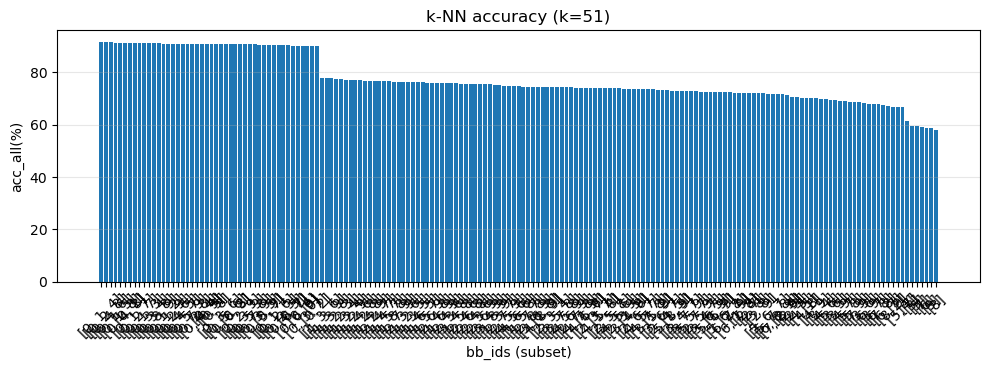

In [16]:
def barplot_knn(df, k, title=None):
    d = df[df["k"] == k].copy()
    fig, ax = plt.subplots(figsize=(10, 3.8))
    ax.bar(d["bb_ids"].values, d["acc_all(%)"].values)
    ax.set_xlabel("bb_ids (subset)")
    ax.set_ylabel("acc_all(%)")
    ax.set_title(title or f"k-NN accuracy (k={k})")
    ax.grid(True, alpha=0.3, axis="y")
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

for k in K_LIST:
    barplot_knn(df_res, k=k)
